# Deterministic material model learning

This is a complete example of using the pyzag bindings to NEML2 to calibrated a material model against experimental data.  `demo_model.i` defines the constitutive model, which is a structural material model describing the evolution of strain and stress in the material under mechanical load.  The particular demonstration is a fairly complex model where the material responds differently as a function of both temperature and strain rate.  The model also reduces the full 3D form of the constitutive model to 1D, where the final model is driven by an axial strain and all the other stress components are zero.

In this example we:
1. Load the model in from file and wrap it for use in pyzag
2. Setup a grid of "experimental" conditions spanning several strain rates and temperatures
3. Replace the original model parameters with samples from a narrow normal distrubtion, centered on the orignial model mean, and run the model over the experimental conditions.  This then becomes our synthetic input data.
4. Replace the original model parameters with random initial guesses (taken from a very wide normal distribution around the true values).
5. Setup the model for training with gradient-descent methods by scaling the model parameters and resulting gradient values.
6. Train the model against the synthetic experimental data.
7. Plot the results and print the trained parameter values, to see how close we can come to the true values.

The accuracy of the final model and the trained parameter values is heavily dependent on the choice of the normal distributions for the synthetic data and the initial parameter guesses.  For narrow distributions for both the model can exactly recover the original parameter values.  For wider distributions the trained model will not be exact, but will still accurately capture the mean of the synthetic tests.

In [1]:
import torch
import torch.distributions as dist
import neml2
from pyzag import nonlinear, reparametrization, chunktime
import matplotlib.pyplot as plt
import tqdm

## Setup parameters related to *how* we train the model

Choose which device to use.  The `nchunk` parameter controls the time integration in `pyzag`.  `pyzag` can vectorize the time integration itself, providing a larger bandwidth to the compute device.  This helps speed up the calculation, particularly when running on a GPU.  The optimal value will depend on your compute device.

In [2]:
torch.manual_seed(0)

torch.set_default_dtype(torch.double)
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

nchunk = 50

## Setup the synthetic experimental conditions

Setup the loading conditions for the "experiments" we're going to run.  These will span several strain rates (`nrate`) and temperatures (`ntemperature`).  Overall, we'll run `nbatch` experiments.  Also setup the maximum strain to pull the material through `max_strain` and the number of time steps we're going to use for integration `ntime`.

In [3]:
nrate = 5
ntemperature = 5
nbatch = nrate * ntemperature
max_strain = 0.25
ntime = 100
rates = torch.logspace(-6,0,nrate, device = device)
temperatures = torch.linspace(310.0,1190.0,ntemperature, device = device)

## Define the variability in the synthetic data and for our initial guess at the parameters

These control the variability in the synthetic data (`actual_cov`) and the variability of the initial guess at the parameter values (`guess_cov`)

In [4]:
actual_cov = 0.025
guess_cov = 0.2

## Setup the actual model

This class is a thin wrapper around the underlying `pyzag` wrapper for NEML2.  All it does is take the input conditions (time, temperature, and strain), combine them into a single tensor, call the `pyzag` wrapper, and return the stress.

In [5]:
class SolveStrain(torch.nn.Module):
    """Just integrate the model through some strain history

    Args:
        discrete_equations: the pyzag wrapped model
        nchunk (int): number of vectorized time steps
        rtol (float): relative tolerance to use for Newton's method during time integration
        atol (float): absolute tolerance to use for Newton's method during time integration
    """
    def __init__(self, discrete_equations, nchunk = 1, rtol = 1.0e-6, atol = 1.0e-4):
        super().__init__()
        self.discrete_equations = discrete_equations
        self.nchunk = nchunk
        self.cached_solution = None
        self.rtol = rtol
        self.atol = atol

    def forward(self, time, temperature, loading, cache = False):
        """Integrate through some time/temperature/strain history and return stress
        Args:
            time (torch.tensor): batched times
            temperature (torch.tensor): batched temperatures
            loading (torch.tensor): loading conditions, which are the input strain in the first base index and then the stress (zero) in the remainder

        Keyword Args:
            cache (bool): if true, cache the solution and use it as a predictor for the next call.
                This heuristic can speed things up during inference where the model is called repeatedly with similar parameter values.
        """
        if cache and self.cached_solution is not None:
            solver = nonlinear.RecursiveNonlinearEquationSolver(
                self.discrete_equations,
                step_generator=nonlinear.StepGenerator(self.nchunk),
                predictor=nonlinear.FullTrajectoryPredictor(self.cached_solution), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
            )
        else:
            solver = nonlinear.RecursiveNonlinearEquationSolver(
                self.discrete_equations, step_generator=nonlinear.StepGenerator(self.nchunk),
                predictor=nonlinear.PreviousStepsPredictor(), nonlinear_solver = chunktime.ChunkNewtonRaphson(rtol = self.rtol, atol = self.atol)
            )

        # We could pass this in as input, but it's easy enough to do here
        control = torch.zeros_like(loading)
        control[...,1:] = 1.0

        # Setup
        forces = self.discrete_equations.forces_asm.assemble_by_variable({'forces/t': time, 'forces/T': temperature, 'forces/fixed_values': loading, 'forces/control': control}).torch()
        state0 = torch.zeros(forces.shape[1:-1] + (self.discrete_equations.nstate,), device = forces.device)

        result =  nonlinear.solve_adjoint(
            solver, state0, len(forces), forces
        )

        if cache:
            self.cached_solution = result.detach().clone()

        return result[...,0:1]

### Actually setup the model

Load the NEML model from disk, wrap it in both the `pyzag` wrapper and our thin wrapper class above.  Exclude some of the model parameters we don't want to train.

In [6]:
nmodel = neml2.load_model("demo_model.i", "implicit_rate")
nmodel.to(device = device)
model = SolveStrain(neml2.pyzag.NEML2PyzagModel(nmodel, exclude_parameters = ["elasticity_E", "elasticity_nu","R_X", "d_X", "mu_X", "mu_Y","yield_zero_sy"]))

## Create the input tensors

Actually setup the full input tensors based on the parameters above

In [7]:
time = torch.zeros((ntime, nrate, ntemperature, 1), device = device)
loading = torch.zeros((ntime, nrate, ntemperature, 6), device = device)
temperature = torch.zeros((ntime, nrate, ntemperature, 1), device = device)
for i, rate in enumerate(rates):
    time[:, i] = torch.linspace(0, max_strain / rate, ntime, device = device)[:, None, None]
loading[...,0] = torch.linspace(0, max_strain, ntime, device = device)[:, None, None]
for i, T in enumerate(temperatures):
    temperature[:, :, i] = T
time = time.reshape((ntime, -1, 1))
temperature = temperature.reshape((ntime, -1, 1))
loading = loading.reshape((ntime, -1, 6))

## Replace the model parameters with random values

Sampled from a normal distribution controlled by the `actual_cov` parameter.

This controls the randomness in the input synthetic test data

In [8]:
# Replace with samples from normal
actual_parameter_values = {}
for n,p in model.named_parameters():
    actual_parameter_values[n] = p.data.detach().clone().cpu()
    ndist = dist.Normal(p.data, torch.abs(p.data) * actual_cov).expand((nbatch,)+p.shape)
    p.data = ndist.sample().to(device)

## Run the model to generate the synthetic data

In [9]:
with torch.no_grad():
    data = model(time, temperature, loading)

## Plot the synthetic data

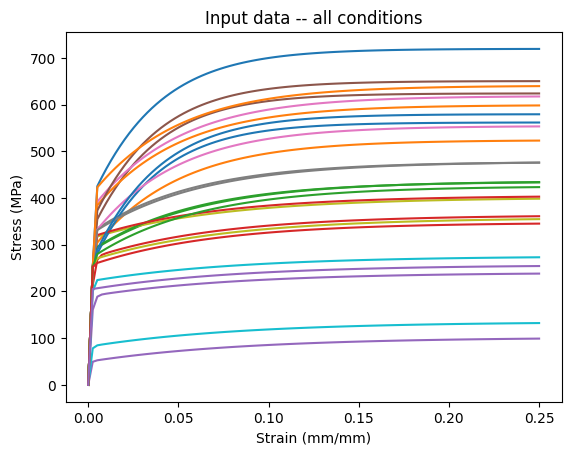

In [10]:
plt.plot(loading.cpu()[...,0], data[...,0].cpu())
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Input data -- all conditions")
plt.show()

## Setup the model for training

Replace the parameter values with random initial guesses, with variability controlled by the `guess_cov` parameter.

In [11]:
# Now replace our original parameter with random values over a range
guess_parameter_values = {}
for n, p in model.named_parameters():
    p.data = torch.normal(actual_parameter_values[n], torch.abs(actual_parameter_values[n])*guess_cov).to(device)
    guess_parameter_values[n] = p.data.detach().clone()

## Scale the model parameters

Our material model parameters have units.  In general, the parameter values will have different magnitudes from each other, which affects the scale of the gradients.  Unbalanced gradients in turn affect the convergence of gradient descent optimization methods.

Typically we'd scale the training data to fix this problem.  However, again our data has units and a physical meaning we want to preserve.

As an alternative we can scale the parameter values themselves both to clip the values to a physical range and to scale the gradients and hopefully improve the convergence of the optimization step.  We do that here, in a way that should be mostly invisible to the training algorithms.

In [12]:
# Scale to get better performance
A_scaler = reparametrization.RangeRescale(torch.tensor(-12.0, device = device), torch.tensor(-4.0, device = device))
B_scaler = reparametrization.RangeRescale(
    torch.tensor(-1.0, device = device), torch.tensor(-0.5, device = device)
)
C_scaler = reparametrization.RangeRescale(torch.tensor(-8.0, device = device), torch.tensor(-3.0, device = device))
R_scaler = reparametrization.RangeRescale(
    torch.tensor([0.0,0.0,0.0,0.0], device=device), torch.tensor([500.0,500.0,500.0,500.0], device=device)
)
d_scaler = reparametrization.RangeRescale(
    torch.tensor([0.01, 0.01, 0.01, 0.01], device=device),
    torch.tensor([50.0, 50.0, 50.0, 50.0], device=device),
)

model_reparameterizer = reparametrization.Reparameterizer(
    {"discrete_equations.A_value": A_scaler,
     "discrete_equations.B_value": B_scaler,
     "discrete_equations.C_value": C_scaler,
     "discrete_equations.R_Y": R_scaler,
     "discrete_equations.d_Y": d_scaler}, error_not_provided=True)
model_reparameterizer(model)

## Run the model with the initial parameter values

Just to see how far away from the training data we starting from.

In [13]:
# Generate the initial results so we know where we are starting from
with torch.no_grad():
    initial_results = model(time, temperature, loading)

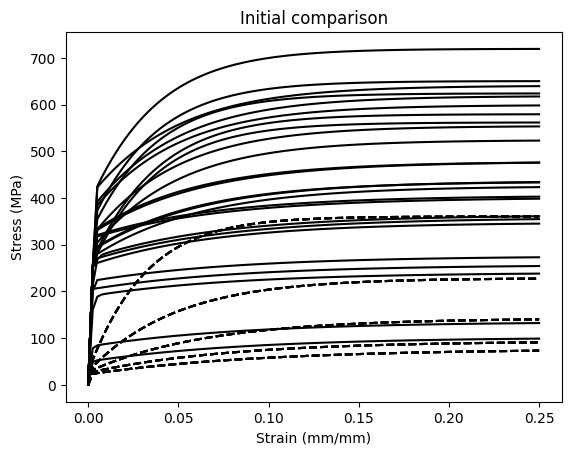

In [14]:
plt.plot(loading.cpu()[..., 0], data.cpu()[...,0], 'k-')
plt.plot(loading.cpu()[..., 0], initial_results.cpu()[...,0], 'k--')
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Initial comparison")
plt.show()

## Train the model against the synthetic data


Apply a fairly standard training algorithm to adjust the model parameters to better match the synthetic data.  Plot the loss versus iteration data from training.

Loss: 2.53e+04: : 100%|██████████|200/200


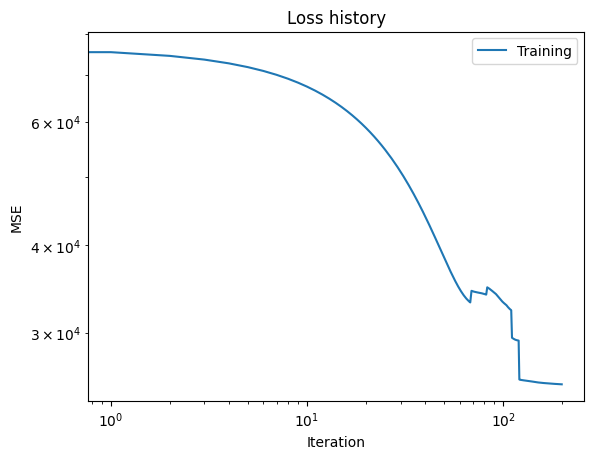

In [15]:
niter = 200
lr = 5.0e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

titer = tqdm.tqdm(
    range(niter),
    bar_format="{desc}: {percentage:3.0f}%|{bar}|{n_fmt}/{total_fmt}{postfix}",
)
titer.set_description("Loss:")
loss_history = []
for i in titer:
    optimizer.zero_grad()
    res = model(time, temperature, loading, cache = True)
    loss = loss_fn(res, data)
    loss.backward()
    loss_history.append(loss.detach().clone().cpu())
    titer.set_description("Loss: %3.2e" % loss_history[-1])
    optimizer.step()

plt.loglog(loss_history, label="Training")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend(loc="best")
plt.title("Loss history")
plt.show()

## Plot the train model predictions

See how accurately the trained model recovers the synthetic data.

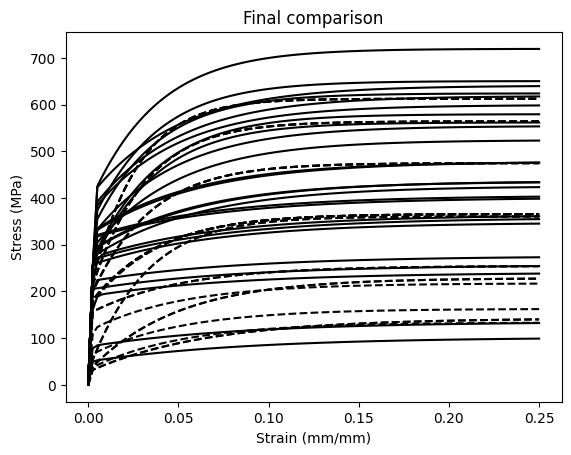

In [16]:
plt.plot(loading.cpu()[..., 0], data.cpu()[...,0], "k-")
plt.plot(loading.cpu()[..., 0], res.detach().cpu()[...,0], "k--")
plt.xlabel("Strain (mm/mm)")
plt.ylabel("Stress (MPa)")
plt.title("Final comparison")
plt.show()

## Print the trained model coefficients

These may vary sigifnicantly from the actual mean values, particularly if you used a large variance when sampling the parameters to generate the synthetic data.

In [17]:
print("The results:")
for n, p in model.discrete_equations.named_parameters():
    nice_name = n.split('.')[-2]
    ref_name = "discrete_equations." + nice_name
    scaler = model_reparameterizer.map_dict[ref_name]
    print(nice_name)
    print("\tInitial: \t" + str(guess_parameter_values[ref_name].cpu()))
    print("\tOptimized: \t" + str(scaler(p.data).cpu()))
    print("\tTrue value: \t" + str(actual_parameter_values[ref_name].cpu()))

The results:
A_value
	Initial: 	tensor(-6.0041)
	Optimized: 	tensor(-8.8544)
	True value: 	tensor(-8.6790)
B_value
	Initial: 	tensor(-0.7877)
	Optimized: 	tensor(-0.9448)
	True value: 	tensor(-0.7440)
C_value
	Initial: 	tensor(-7.7675)
	Optimized: 	tensor(-5.8379)
	True value: 	tensor(-5.4100)
R_Y
	Initial: 	tensor([334.1059, 156.6191,  72.0281,  54.0335])
	Optimized: 	tensor([391.3500, 342.9170, 215.5261,  95.8723])
	True value: 	tensor([300., 200., 100.,  50.])
d_Y
	Initial: 	tensor([35.0282, 17.1230, 13.7900, 10.5681])
	Optimized: 	tensor([43.9882, 34.7154, 30.0079, 19.7839])
	True value: 	tensor([30., 20., 15., 12.])
